In [1]:
using StanSample, Distributions, Dates
using DataFrames, CSV

In [2]:
ENV["JULIA_CMDSTAN_HOME"] = expanduser("~/cmdstan");

## Ideal workflow

In [3]:
include("../src/rt-from-frequency-dynamics.jl")
using .rt_from_frequency_dynamics

In [4]:
# 1. Get data
synthetic_df = DataFrame(CSV.File("../data/processed/synthetic_data.csv"))
LD = LineageData(synthetic_df)

LineageData([19 0; 23 0; … ; 0 43; 0 47], [47, 38, 40, 55, 101, 128, 84, 67, 39, 83  …  105267, 73428, 70005, 48762, 67824, 101205, 47607, 89804, 224882, 195666], ["A", "B"], [Date("2020-01-01"), Date("2020-01-02"), Date("2020-01-03"), Date("2020-01-04"), Date("2020-01-05"), Date("2020-01-06"), Date("2020-01-07"), Date("2020-01-08"), Date("2020-01-09"), Date("2020-01-10")  …  Date("2021-01-25"), Date("2021-01-26"), Date("2021-01-27"), Date("2021-01-28"), Date("2021-01-29"), Date("2021-01-30"), Date("2021-01-31"), Date("2021-02-01"), Date("2021-02-02"), Date("2021-02-03")])

In [5]:
# 2. Get lifetimes
g, onset = get_standard_delays()

([0.0013570708164475438, 0.030252383582115523, 0.1248726218372186, 0.21989262129982626, 0.23434297788835956, 0.1800507935166118, 0.11003557415528875, 0.05680884455133395, 0.025772058657759778, 0.010556189208093536, 0.003980424684790984, 0.0014017344178233193, 0.0004660914523152426], [3.8872052302944836e-7, 0.0013781561063394194, 0.055284375808597706, 0.3417218112141225, 0.780268761669684, 1.0, 0.9014831923033185, 0.6502995817497046, 0.4056024823983106, 0.22963239715075728, 0.12180655617080503, 0.06183884788596803, 0.030491658924558254, 0.014754237581045646, 0.00705796544686744, 0.0033558114933791216, 0.0015921209508521382])

In [6]:
# 3. Create the rt_model
model = SplineTrend(20,  length(LD.cases), 4)
priors = [["LAS"]]
seed_L = 7
forecast_L = 0
LM = FreeLineageModel(g, onset, model, priors, seed_L, forecast_L)

FreeLineageModel{Float64}([0.0013570708164475438, 0.030252383582115523, 0.1248726218372186, 0.21989262129982626, 0.23434297788835956, 0.1800507935166118, 0.11003557415528875, 0.05680884455133395, 0.025772058657759778, 0.010556189208093536, 0.003980424684790984, 0.0014017344178233193, 0.0004660914523152426], [3.8872052302944836e-7, 0.0013781561063394194, 0.055284375808597706, 0.3417218112141225, 0.780268761669684, 1.0, 0.9014831923033185, 0.6502995817497046, 0.4056024823983106, 0.22963239715075728, 0.12180655617080503, 0.06183884788596803, 0.030491658924558254, 0.014754237581045646, 0.00705796544686744, 0.0033558114933791216, 0.0015921209508521382], SplineTrend(20, [1.0, 21.999999999999996, 42.99999999999999, 64.0, 84.99999999999999, 106.0, 127.0, 147.99999999999997, 168.99999999999997, 189.99999999999997, 211.0, 232.00000000000003, 253.0, 274.0, 294.99999999999994, 316.0, 336.99999999999994, 358.0, 378.99999999999994, 400.0], 4), [["LAS"]], 7, 0)

In [7]:
MS = make_stan(LM, LD, "test_model", "../data/sims/test_interface/synth")

Main.rt_from_frequency_dynamics.ModelStan(SampleModel("test_model", "\nfunctions {\n  int get_L_nonzero(int[] Z, int L){\n    int L_nonzero = 0;\n    for (i in 1:L){\n      if(Z[i] > 0){ \n        L_nonzero += 1;\n      }\n    }\n    return L_nonzero;\n  }\n\n  int[] get_nonzero_idx(int[] Z, int L_nonzero, int L){\n    int cur_idx = 1;\n    int non_zero_idx[L_nonzero];\n\n    for (i in 1:L){\n      if(Z[i] > 0){\n        non_zero_idx[cur_idx] = i;\n        cur_idx += 1;\n      }\n    }\n    return non_zero_idx;\n  }\n\n\n  matrix get_weekend_mat(int L){\n        matrix[L, 7] wk_mat = rep_matrix(0, L, 7);\n        for (i in 1:L){\n           wk_mat[i, (i % 7)+1] = 1;\n        }\n        return(wk_mat);\n    }\n\n  vector get_infections(vector R, real I0, vector g_rev, int T, int l, int seed_L){\n    vector[T] I;\n    I[1:seed_L] = rep_vector(I0, seed_L);\n\n    // Loop for dates without full backlog\n    for (t in seed_L:(l-1)){\n      I[t+1] = R[t-seed_L+1] * dot_product(I[1:t], tail(g

In [8]:
#run!(MS, num_warmup=1000, num_samples = 1000, num_chains = 4)

In [9]:
load_samples!(MS)

8895-element Vector{String}:
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 "b.7.1"
 "b.8.1"
 "b.9.1"
 "b.10.1"
 "b.11.1"
 "b.12.1"
 "b.13.1"
 ⋮
 "obs_freqs.389.2"
 "obs_freqs.390.2"
 "obs_freqs.391.2"
 "obs_freqs.392.2"
 "obs_freqs.393.2"
 "obs_freqs.394.2"
 "obs_freqs.395.2"
 "obs_freqs.396.2"
 "obs_freqs.397.2"
 "obs_freqs.398.2"
 "obs_freqs.399.2"
 "obs_freqs.400.2"

In [10]:
using CairoMakie

In [11]:
# To get pre-print colors, we use
#lineage_map = get_sequence_map(seq_labels)
#colors = [lineage_colors[lineage_map[n]] for n in seq_labels]

#lineage_colors =["#2e5eaa", "#5adbff", "#b4c5e4","#f5bb00","#56e39f", "#9e4244", "#f03a47", "#808080"] 
colors =  ["green", "hotpink"]
alphas = [0.65, 0.45, 0.35]
ps = [0.5, 0.8, 0.95]

1×3 Matrix{Float64}:
 0.5  0.8  0.95

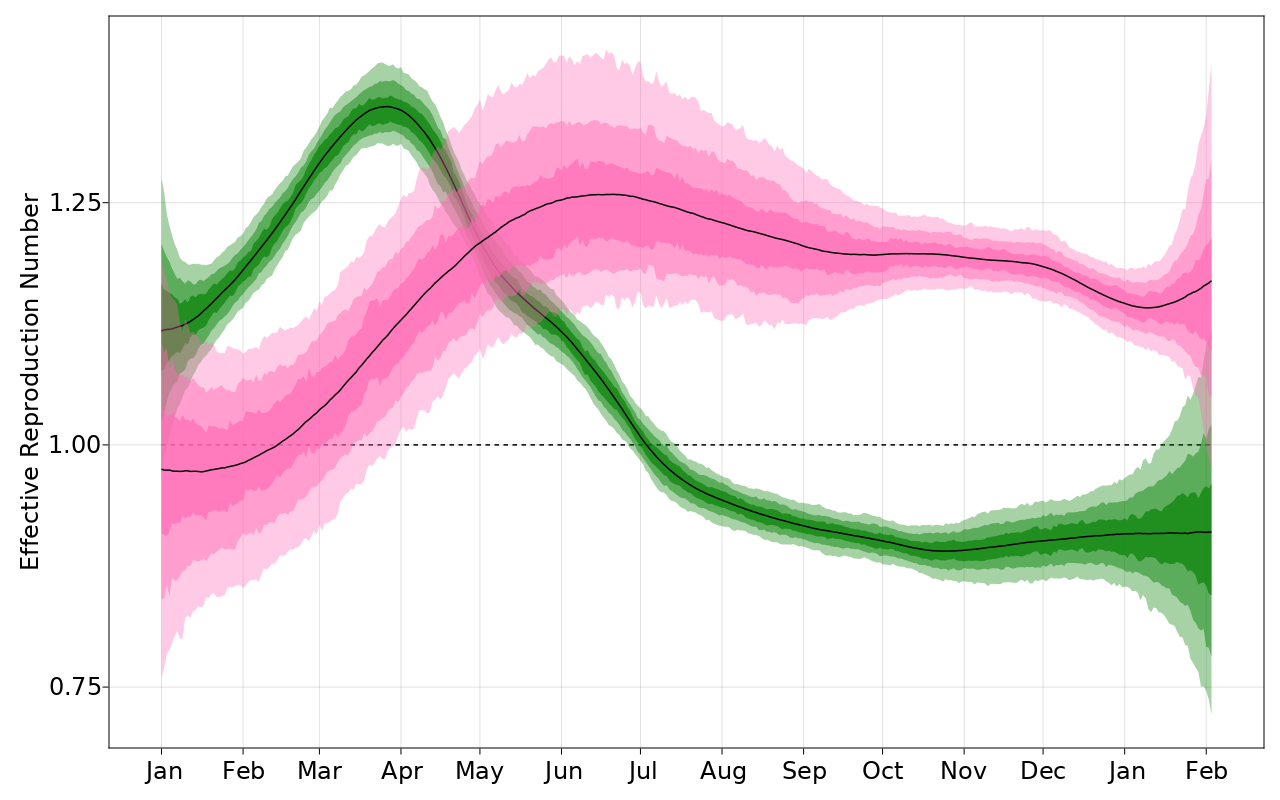

In [12]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Effective Reproduction Number")
plot_lineage_R!(ax, MS, colors = colors)
add_monthly_dates!(ax, LD.dates)

fig

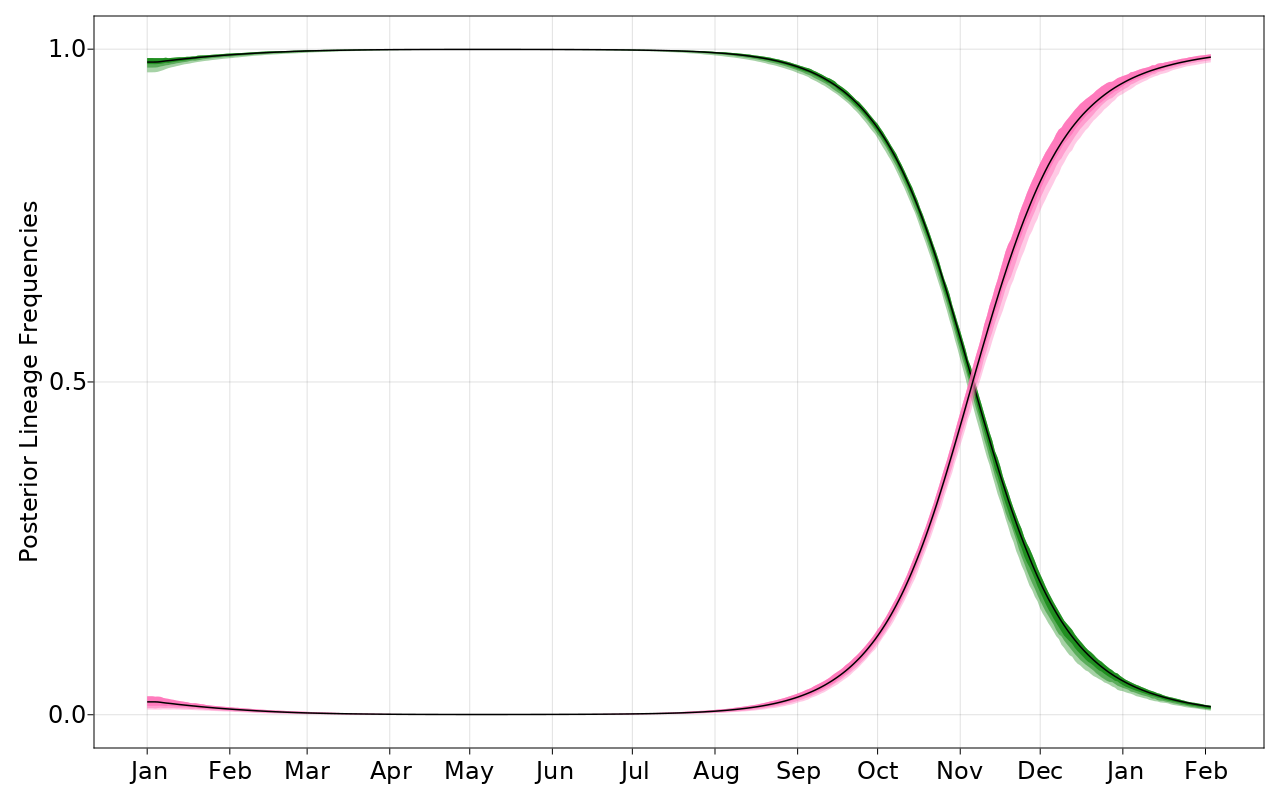

In [13]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Lineage Frequencies")
plot_lineage_frequency!(ax, MS, colors = colors)
add_monthly_dates!(ax, LD.dates)

fig

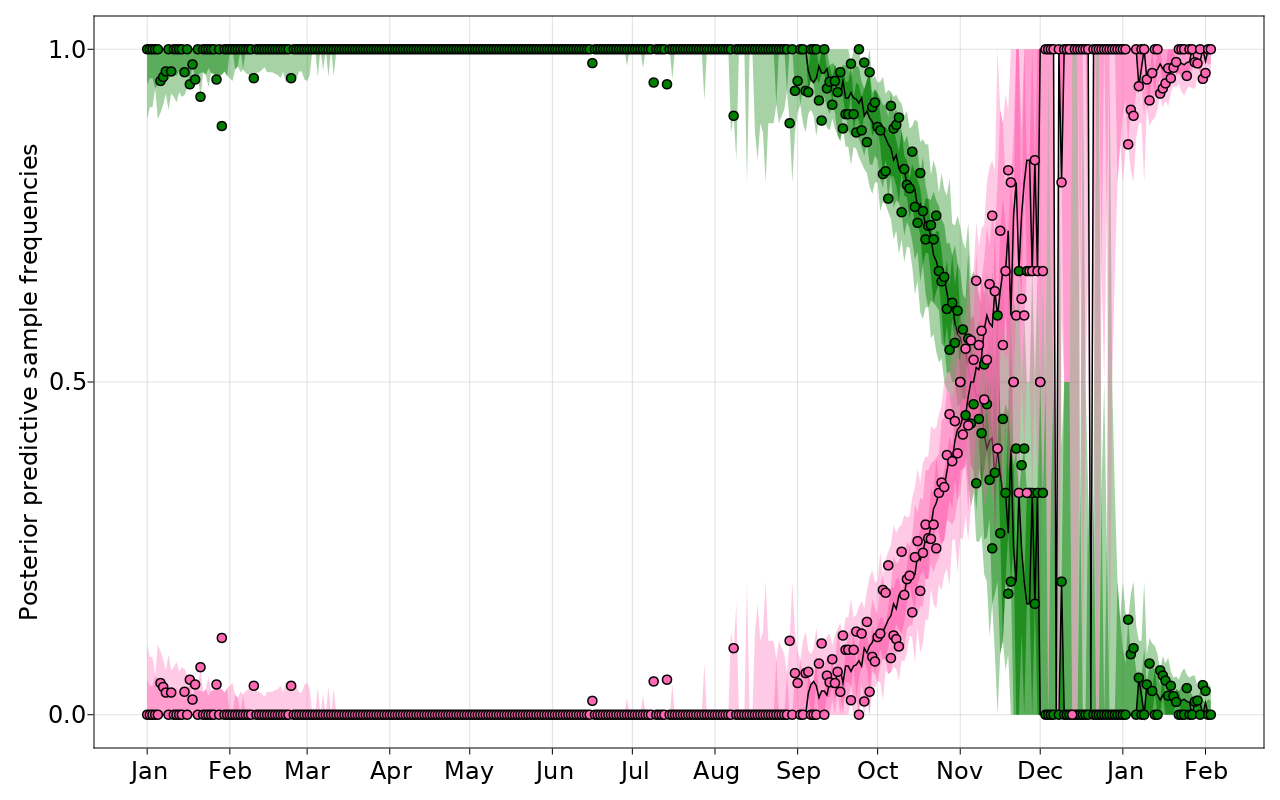

In [14]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior predictive sample frequencies")

plot_frequency_ppc!(ax, MS, colors = colors)
plot_observed_frequencies!(ax, MS, colors = colors)
add_monthly_dates!(ax, LD.dates)

fig

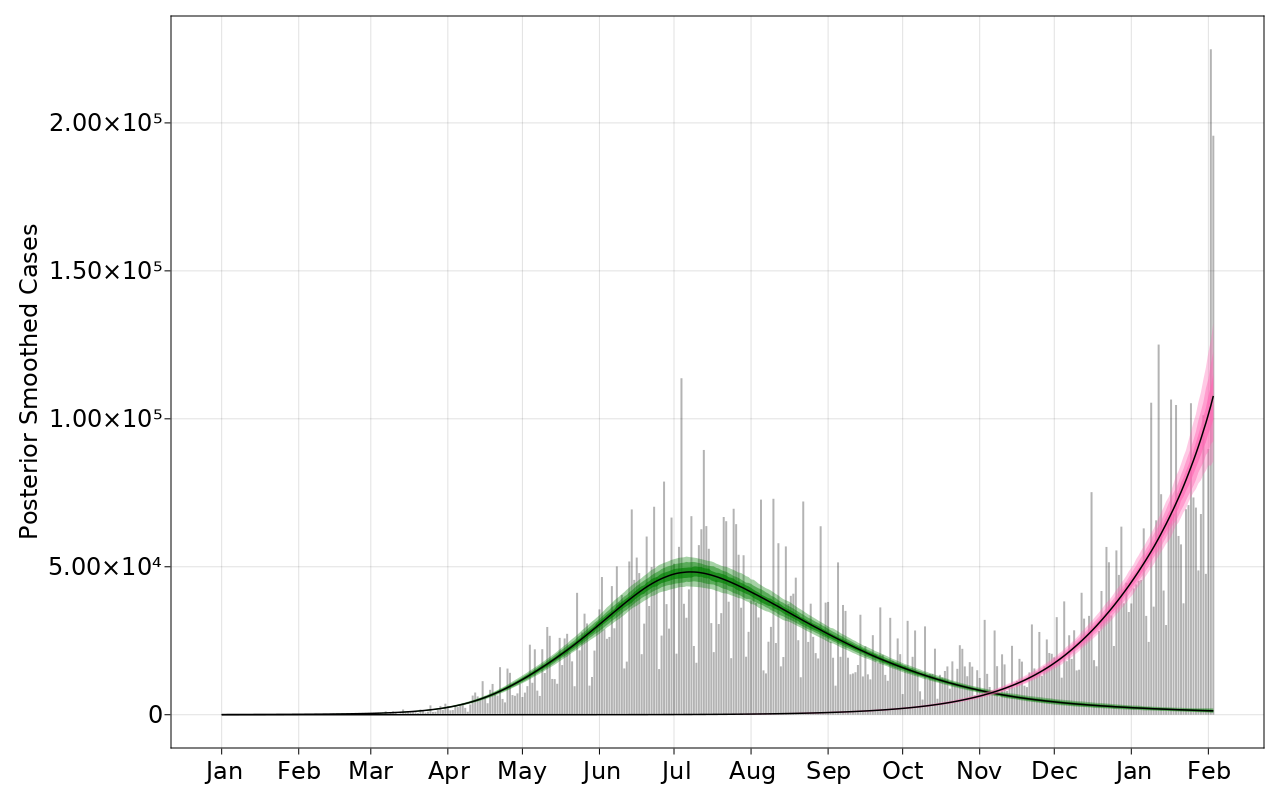

In [15]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")
plot_cases!(ax, MS)
plot_lineage_prev!(ax, MS, colors = colors)
add_monthly_dates!(ax, LD.dates)

fig

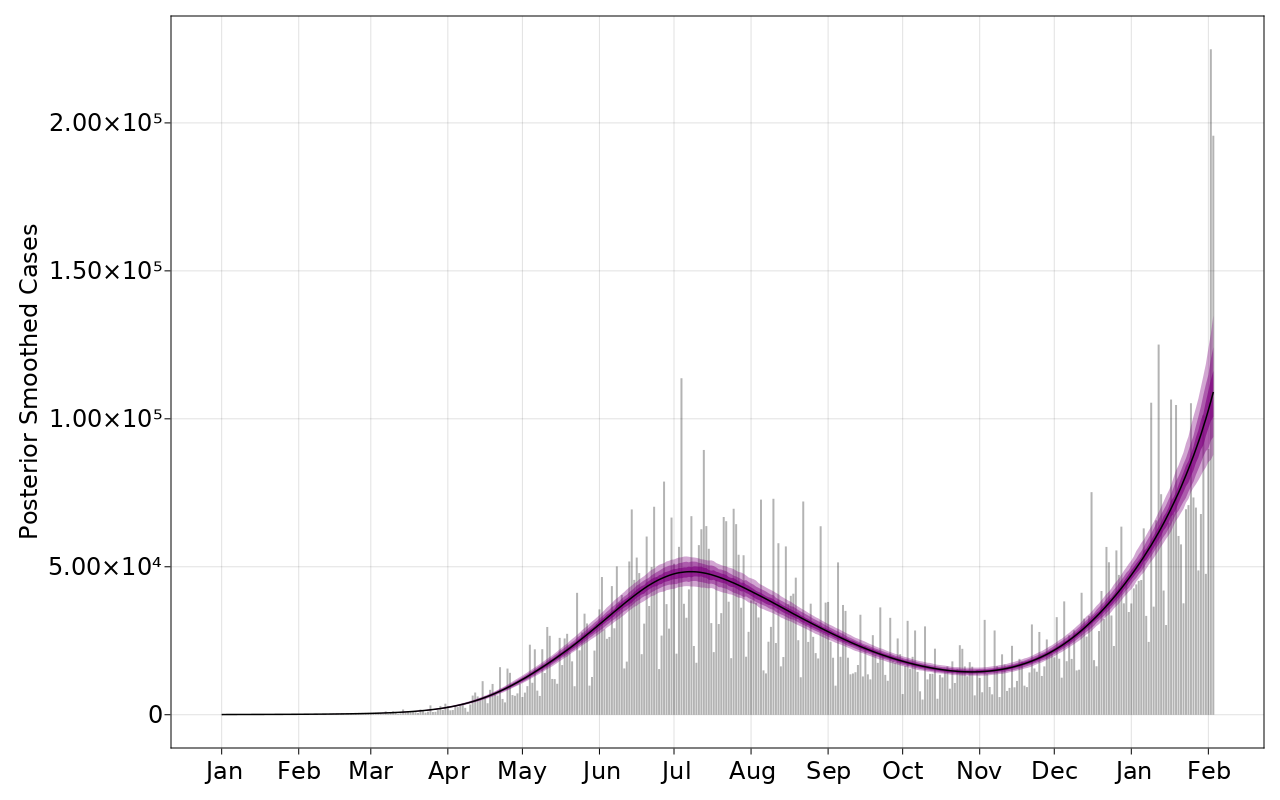

In [16]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Posterior Smoothed Cases")
plot_cases!(ax, MS)
plot_smoothed_EC!(ax, MS)
add_monthly_dates!(ax, LD.dates)
fig

In [17]:
get_Rt_dataframe(MS, LD)

,state,date,lineage,rt_median,rt_lower_50,rt_upper_50,rt_lower_80
,Any,Any,Any,Any,Float64,Float64,Float64
1,test_model,2020-01-01,A,1.1178,1.07612,1.16622,1.07785
2,test_model,2020-01-02,A,1.11859,1.07612,1.16622,1.07785
3,test_model,2020-01-03,A,1.11929,1.07612,1.16622,1.07785
4,test_model,2020-01-04,A,1.11919,1.07612,1.16622,1.07785
5,test_model,2020-01-05,A,1.11979,1.07612,1.16622,1.07785
6,test_model,2020-01-06,A,1.12071,1.07612,1.16622,1.07785
7,test_model,2020-01-07,A,1.12167,1.07612,1.16622,1.07785
8,test_model,2020-01-08,A,1.12247,1.07612,1.16622,1.07785
9,test_model,2020-01-09,A,1.12321,1.07612,1.16622,1.07785


In [21]:
function make_plot_dataframe(obs_cases, obs_counts, lineage_names)
    cases = Int[]
    counts = Int[]
    obs_freqs = Float64[]
    dates = Int[]
    lineages = String[]
    lineages_num = Int[]
   # state = String[]
    
    T = length(obs_cases)
    N_lineage = size(obs_counts,2)
    
    obs_freq = obs_counts ./ sum(obs_counts, dims=2)
    
    
    for lineage in 1:N_lineage
        dates = vcat(dates, collect(1:T))
        cases = vcat(cases, obs_cases)
        counts = vcat(counts, obs_counts[:, lineage])
        obs_freqs = vcat(obs_freqs, obs_freq[:, lineage])
        lineages_num = vcat(lineages_num, repeat([lineage], T))
        lineages  = vcat(lineages, repeat([lineage_names[lineage]], T))
    #    state = vcat(state, repeat([state_name], T))
    end
    
    return DataFrame(date = dates, cases = cases, counts = Int.(counts), obs_freqs = obs_freqs, lineage = lineages, lineage_num = lineages_num) #, state = state)   
end

make_plot_dataframe (generic function with 2 methods)

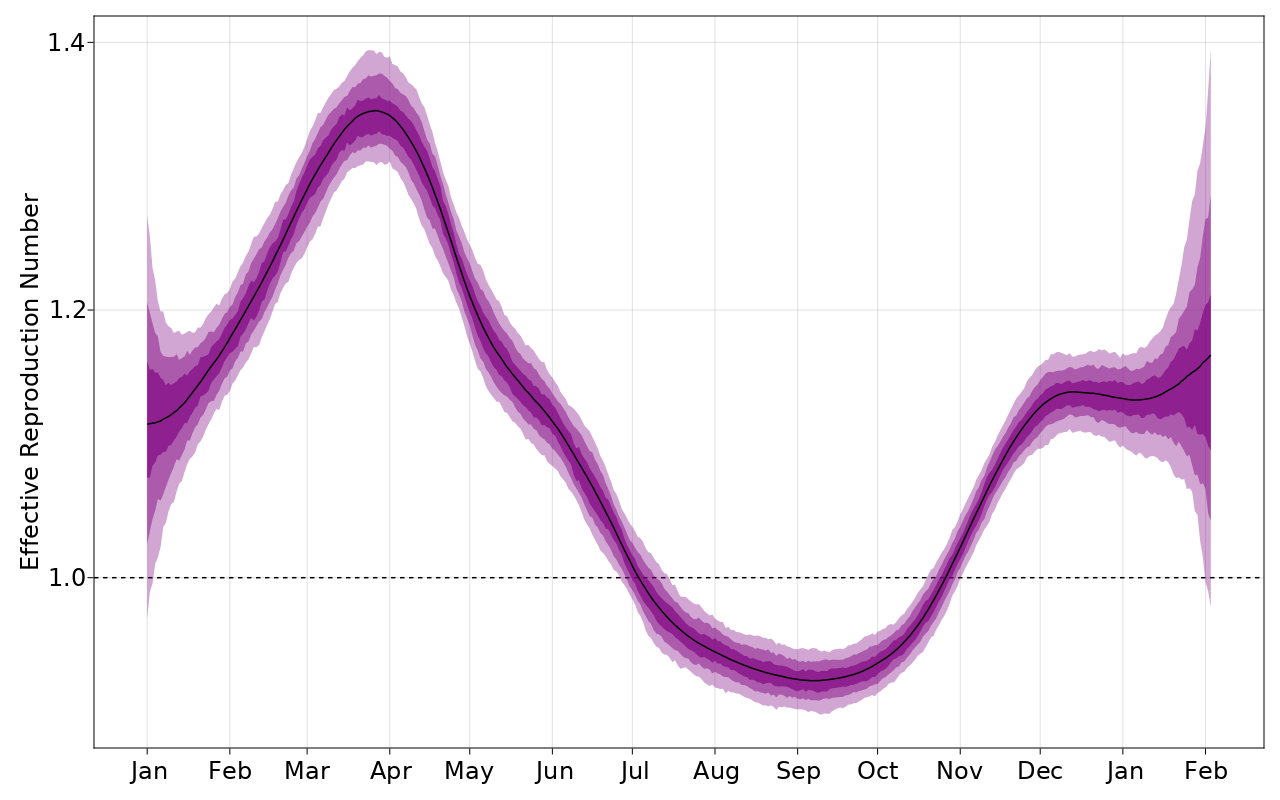

In [74]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1,1] = Axis(fig, ylabel = "Effective Reproduction Number")
plot_average_R!(ax, MS)
add_monthly_dates!(ax, LD.dates)

fig

In [95]:
function figure_1(MS, LD, colors; figsize=(3200, 2600), fontsize=32, font="Helvetica")
    dates_num, seed_L, forecast_L, N_lineage = unpack_data(MS)
    seq_labels = LD.seq_names
    dates = LD.dates 

    lineage_map = get_sequence_map(seq_labels)
    cases = MS.data["cases"]
    counts =  MS.data["num_sequenced"]
    plot_data = make_plot_dataframe(cases, counts, seq_labels)
    color_vec = [colors[i] for i in plot_data.lineage_num]
    
    fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (3200, 2600), fontsize = fontsize, font = font)
 
    g_cases_rt =  fig[1:3,1:2] = GridLayout()
    
    ##################### CASES AND AGGREGATE SMOOTH ###############
    ax_cases = Axis(g_cases_rt[1:2,1], ylabel = "Observed Cases")
    plot_cases!(ax_cases, MS)
    plot_smoothed_EC!(ax_cases, MS)
    add_monthly_dates!(ax_cases, LD.dates)
    hidexdecorations!(ax_cases, grid = false)
    
    ###################### AVERAGE RT ##############################
    ax_average_rt = Axis(g_cases_rt[3,1], ylabel = L"R_{t}")
    plot_average_R!(ax_average_rt, MS)
    add_monthly_dates!(ax_average_rt, LD.dates)
    linkxaxes!(ax_cases, ax_average_rt)

    g_variant = fig[1:3, 3:4] = GridLayout()
    
    ###################### Lineage Prevalence ######################
    ax_smooth_lin = Axis(g_variant[1:2,1:2])
    plot_lineage_prev!(ax_smooth_lin, MS, colors = colors)
    add_monthly_dates!(ax_smooth_lin, LD.dates)
    hidexdecorations!(ax_smooth_lin, grid = false)
    
    ###################### Lineage Effective Reproductive Number ###
    ax_Rt = Axis(g_variant[3,1:2])
    plot_lineage_R_censored!(ax_Rt, MS, colors = colors)
    add_monthly_dates!(ax_Rt, LD.dates)
    linkxaxes!(ax_smooth_lin, ax_Rt)

    ##################### PLOTTING ORIGINAL SAMPLES ################
    g_seq_count = fig[4:5,1:4] = GridLayout()
    
    ax_obs_cases = Axis(g_seq_count[1:2,2], ylabel = "Observed Cases")
    plot_cases!(ax_obs_cases, MS)
    add_monthly_dates!(ax_obs_cases, LD.dates, skip = 2)
    
    ax_seq_count = Axis(g_seq_count[1,1], ylabel = "Observed Counts")
    barplot!(ax_seq_count, plot_data.date, plot_data.counts, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    ##################### PLOTTING OBSERVED FREQ ################
    ax_seq_freq = Axis(g_seq_count[2,1], ylabel = "Sample Frequency")
    barplot!(ax_seq_freq, plot_data.date, plot_data.obs_freqs, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    linkxaxes!(ax_seq_count, ax_seq_freq)
    hidexdecorations!(ax_seq_count, grid = false)
    
    add_monthly_dates!(ax_seq_freq, LD.dates, skip=2)

    
    ##################### PLOTTING APPROX LINEAGE ################
    
    ax_true_cases = Axis(g_seq_count[1:2,3])
    
    sim_freq = get_posterior(MS, "sim_freq", true)
    med, lQ, uQ = get_quants(sim_freq, ps)
    
    plot_data.sim_freqs = reduce(vcat, [m for m in eachcol(med)])
    barplot!(ax_true_cases, plot_data.date, plot_data.cases .* plot_data.sim_freqs, 
        stack = plot_data.lineage_num,
        color = color_vec)    
    
    add_monthly_dates!(ax_true_cases, LD.dates, skip=2)

    linkyaxes!(ax_obs_cases, ax_true_cases)
    hideydecorations!(ax_true_cases, grid = false)

    for (label, layout) in zip(["(a)", "(b)", "(c)"], [g_cases_rt, g_seq_count, g_variant])
    Label(layout[1, 1, TopLeft()], label,
        textsize = fontsize * 1.8,
        padding = (0, 5, 5, 0),
        font = font,
        halign = :right)
    end
    
    return fig
end

figure_1 (generic function with 2 methods)

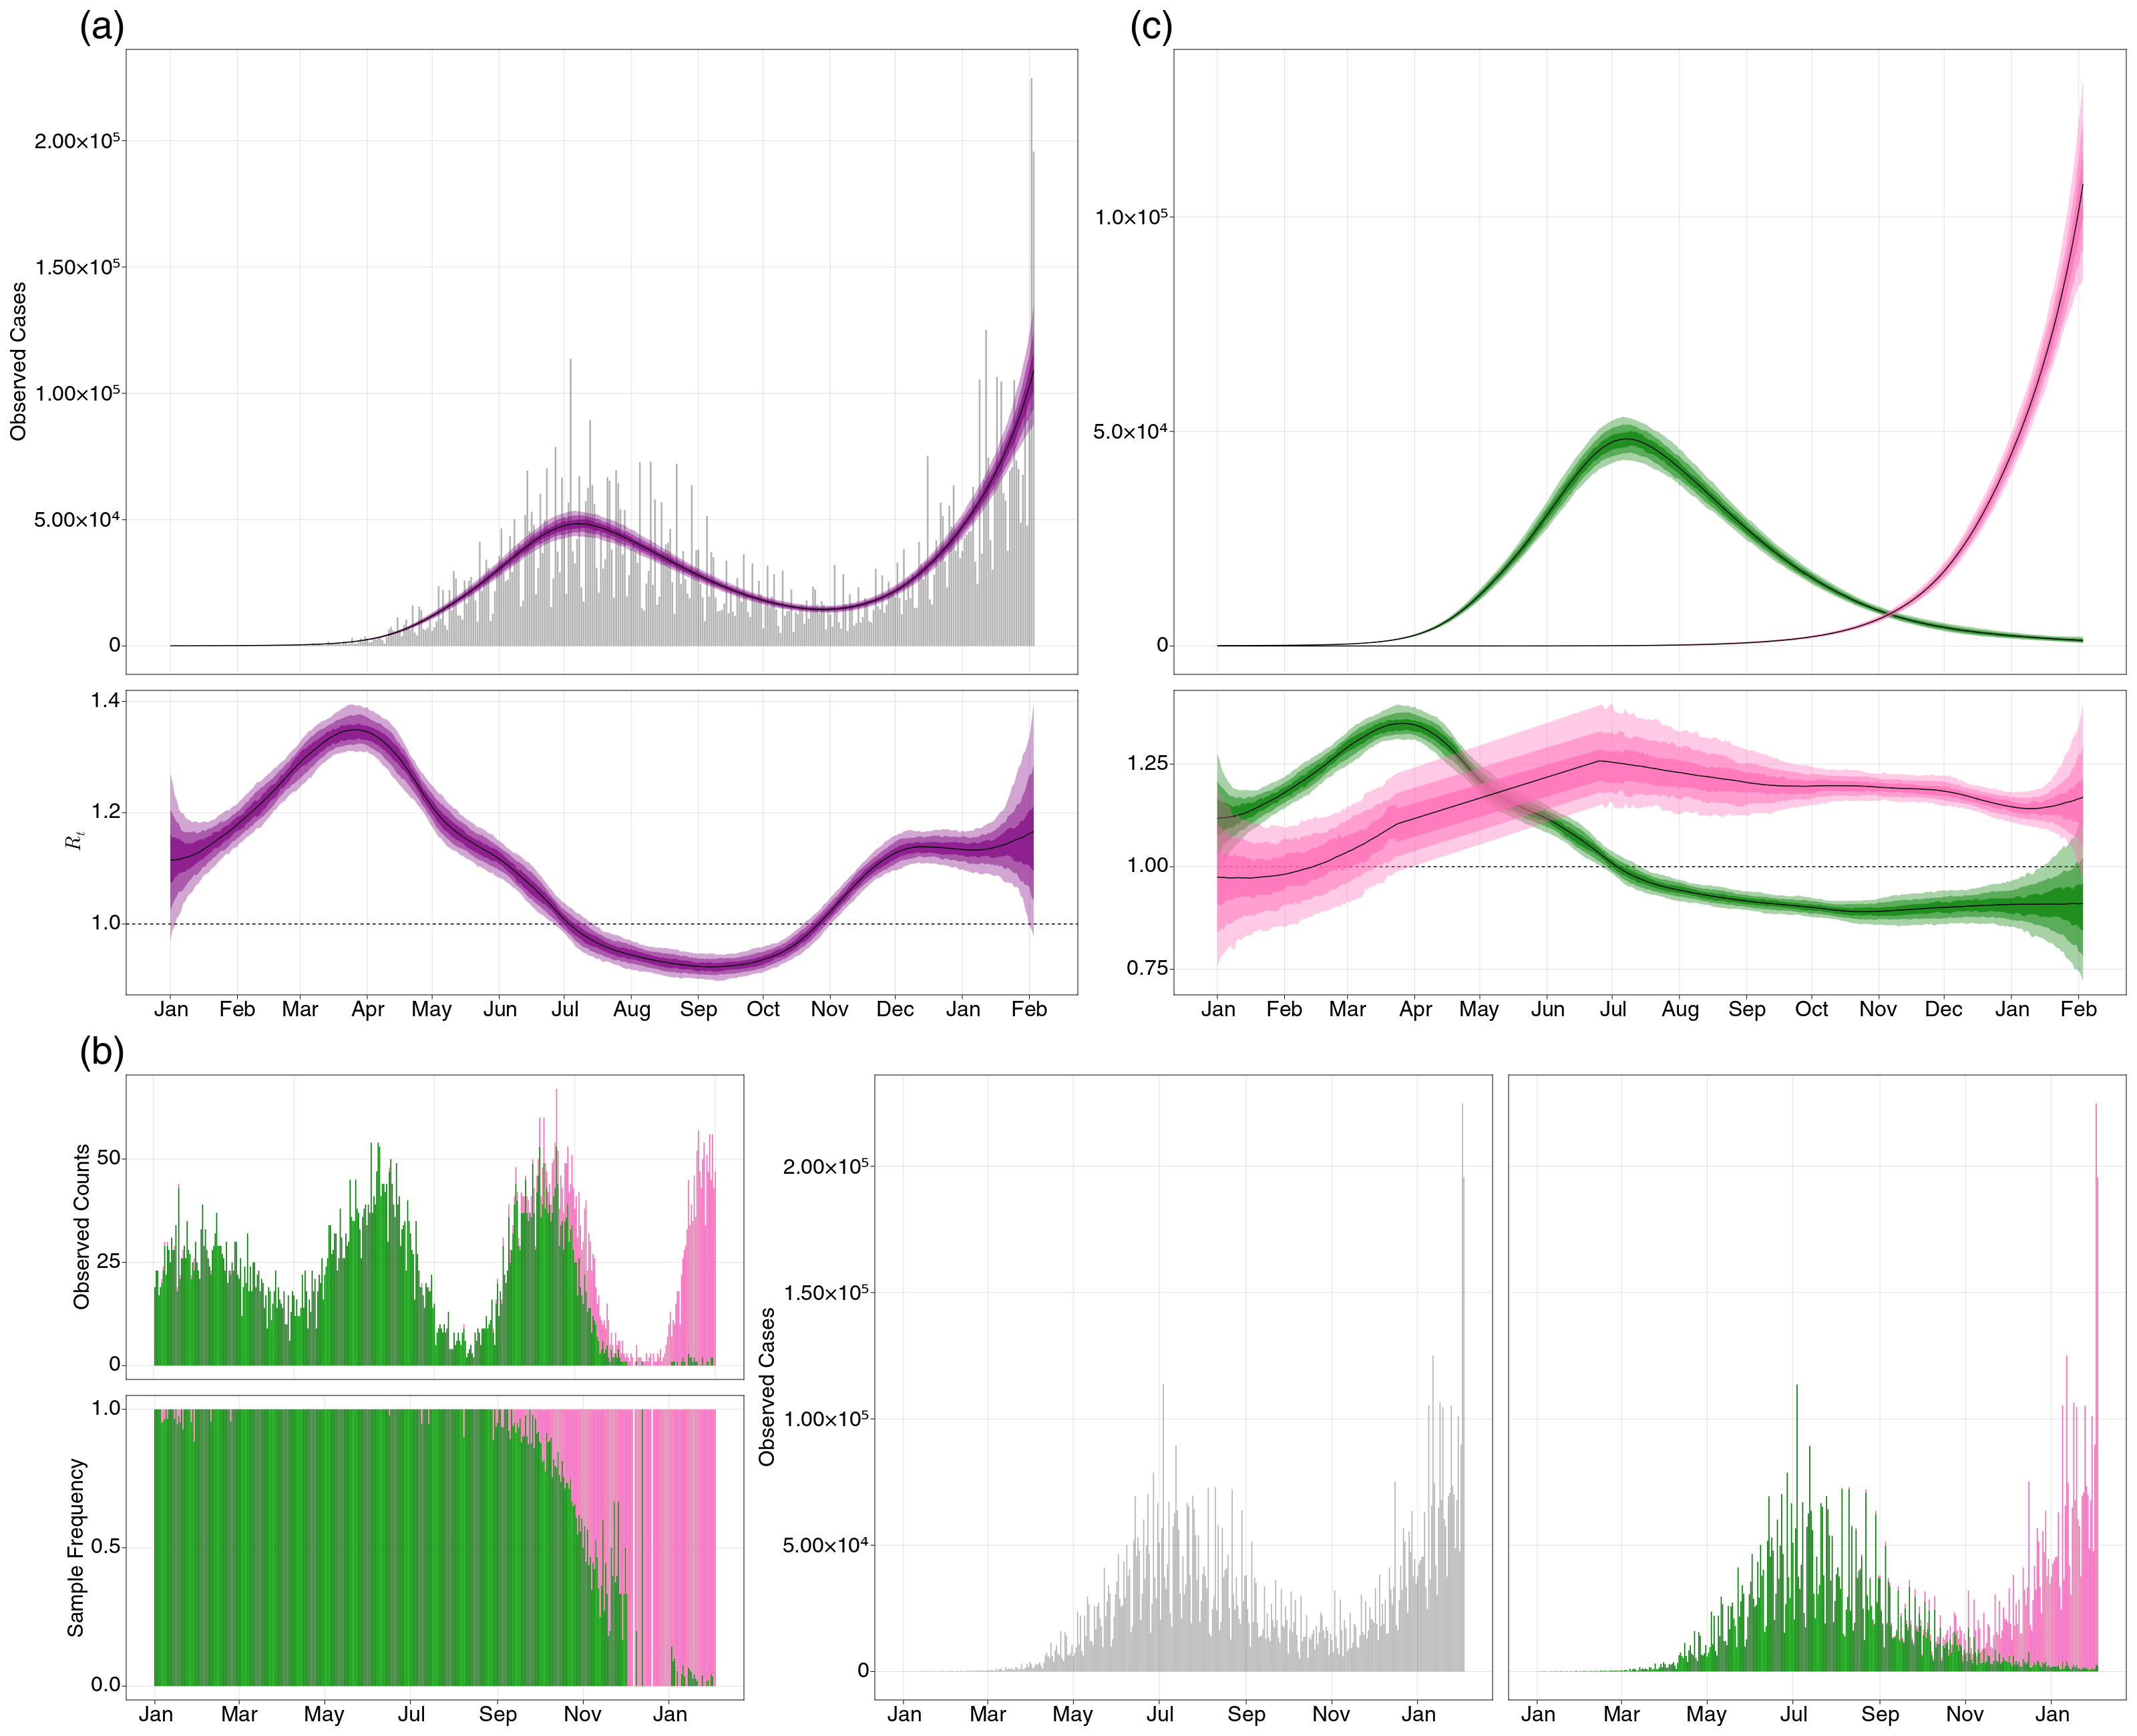

In [96]:
figure_1(MS, LD, colors)